# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close

In [3]:
%run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [14]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_102444\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [16]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,1720.24,1.00,-131.89,-464.68,-596.57
BTCUSDT,601.02,753.12,0.44,3.54,152.10,155.64
OMUSDT,526.32,306.78,0.18,0.00,-219.54,-219.54
SOLUSDT,281.20,242.00,0.14,0.00,-39.20,-39.20
JASMYUSDT,387.46,172.70,0.10,0.00,-214.75,-214.75
TRXUSDT,76.87,121.40,0.07,-10.72,44.53,33.81
ETHUSDT,250.75,111.62,0.06,0.00,-139.13,-139.13
BBUSDT,60.18,11.62,0.01,-39.73,-48.56,-88.29
BNBUSDT,1.14,1.01,0.00,-10.61,-0.13,-10.74
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [20]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

3

In [21]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [22]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [23]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [24]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [25]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [26]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [28]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 47bb7d6a9beb0b2cbb5902f9384df4d66e7bfca5)
✅ File pushed/updated successfully!


In [29]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [31]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [32]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 519e1952478b52d1154569da788aecf3726a1634)
✅ File pushed/updated successfully!


In [33]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [34]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [35]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [36]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [37]:
# pnl_history['Total']

In [38]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [39]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [40]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [41]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [42]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-04-12    2045.258120
2025-04-13    -428.089866
2025-04-14    -609.796018
2025-04-15    -558.441432
2025-04-16    -458.200623
Name: Total, Length: 206, dtype: float64

<Axes: >

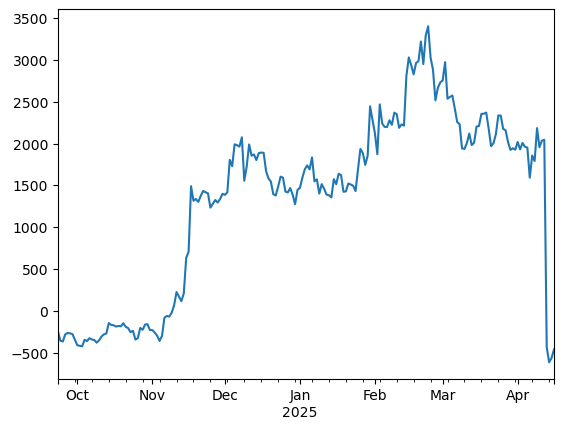

In [43]:
pnl_history['Total'].plot()

In [44]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23            NaN
2024-09-24    -108.382879
2024-09-25     -11.102127
2024-09-26      85.699217
2024-09-27      16.519121
                 ...     
2025-04-12      10.435199
2025-04-13   -2473.347985
2025-04-14    -181.706152
2025-04-15      51.354585
2025-04-16     100.240809
Name: Total, Length: 206, dtype: float64

In [45]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,5)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-228.0424561385975, -531.5492437138698)

In [46]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [47]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [48]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [49]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [50]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [51]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [52]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

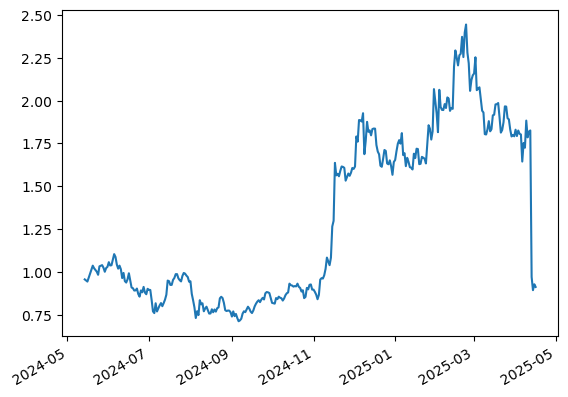

In [53]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

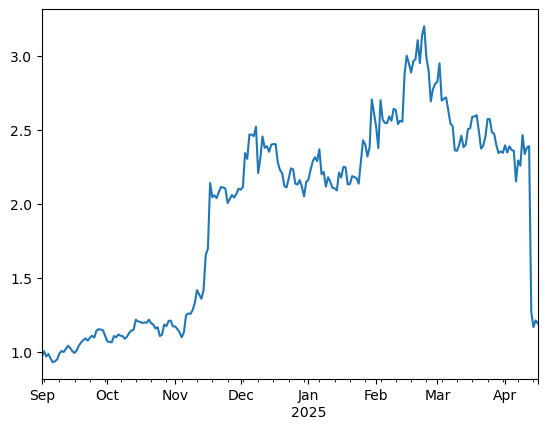

In [54]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [56]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [59]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [60]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.7830
AAVEUSDT,0.1325
OMUSDT,0.0399
TRXUSDT,0.0287
DEXEUSDT,0.0110
PEPEUSDT,0.0049
XRPUSDT,0.0000
LDOUSDT,0.0000
WLDUSDT,0.0000
ARBUSDT,0.0000


In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.642812
BTCUSDT,0.300000
OMUSDT,0.030230
TRXUSDT,0.026306
DEXEUSDT,0.000653


In [65]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

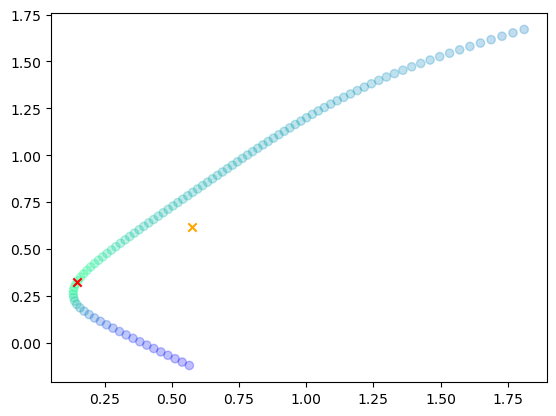

In [66]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [67]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [68]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,753.117561,0.437799,0.0000,0.437799
OMUSDT,306.779379,0.178336,0.0126,0.165736
SOLUSDT,241.996289,0.140676,0.0000,0.140676
JASMYUSDT,172.704174,0.100396,0.0000,0.100396
TRXUSDT,121.395626,0.070569,0.0177,0.052869
ETHUSDT,111.616963,0.064885,0.0000,0.064885
BBUSDT,11.617937,0.006754,0.0000,0.006754
BNBUSDT,1.008935,0.000586,0.0624,-0.061814
PEPEUSDT,0.000002,0.000000,0.0155,-0.015500
PAXGUSDT,0.000000,0.000000,0.4226,-0.422600


### Current results

In [70]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [71]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.931045
TRXUSDT,0.050137
BTCUSDT,0.018818


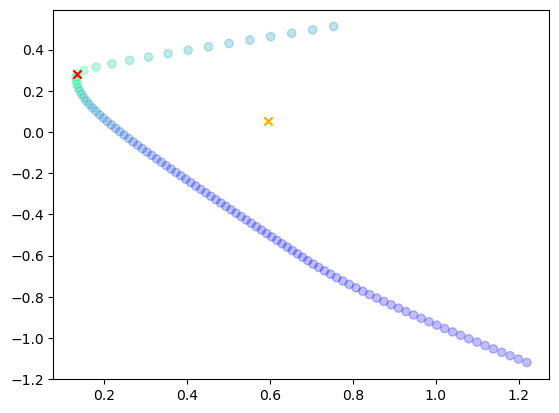

In [72]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [73]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,753.117561,0.437799,0.018818,0.418981
OMUSDT,306.779379,0.178336,0.000000,0.178336
SOLUSDT,241.996289,0.140676,0.000000,0.140676
JASMYUSDT,172.704174,0.100396,0.000000,0.100396
TRXUSDT,121.395626,0.070569,0.050137,0.020432
ETHUSDT,111.616963,0.064885,0.000000,0.064885
BBUSDT,11.617937,0.006754,0.000000,0.006754
BNBUSDT,1.008935,0.000586,0.000000,0.000586
PEPEUSDT,0.000002,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.931045,-0.931045


# Risk Reward Analysis

In [75]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [76]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

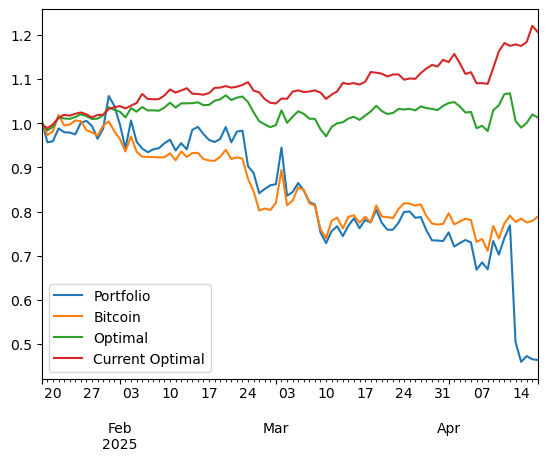

In [77]:
days=90
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [78]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

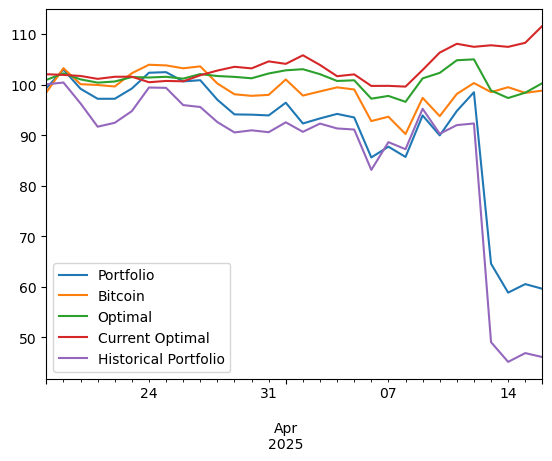

In [79]:
days=30
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [80]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-04-07,110.042871,104.970749,128.732116,126.390752,175.250279
2025-04-08,107.493255,101.134560,127.194791,126.199516,172.487080
2025-04-09,117.790747,109.147167,133.304529,130.376450,188.295013
2025-04-10,112.837612,105.099102,134.731237,134.723322,178.519017
2025-04-11,118.893325,110.020717,138.017394,136.927628,181.912504
2025-04-12,123.540686,112.437816,138.253480,136.167232,182.539832
2025-04-13,81.021030,110.419777,130.143164,136.553888,97.040064
2025-04-14,73.844148,111.510633,128.185093,136.156137,89.331392
2025-04-15,75.957607,110.254448,129.573765,137.175296,92.766732
2025-04-16,74.800447,110.762591,132.050968,141.413427,91.212453


## Volatilities

In [82]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.189105
 dtype: float64,
 0.18929036702864524)

In [83]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.594973
 dtype: float64,
 0.5949732172214668)

In [84]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.577429
Bitcoin            0.434874
Optimal            0.189290
Current Optimal    0.134626
dtype: float64

In [85]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.6112136210754476

In [86]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-3.3502482695141698

In [87]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.09301864378116544

## Risk Contribution

In [89]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.260445,0.300000,0.750341,0.573223,0.475021,0.098202
DEXEUSDT,0.000541,0.000653,0.001599,0.001131,0.000010,0.001121
OMUSDT,-0.929034,0.030230,-1.203346,0.136752,0.083626,0.053126
PAXGUSDT,0.396578,0.642812,1.391569,0.263519,0.217847,0.045671
TRXUSDT,0.018388,0.026306,0.059838,0.025376,0.007926,0.017450


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.003793,0.018818,0.015968,0.015006,0.003396,0.011611
TRXUSDT,0.022072,0.050137,0.050995,0.091411,0.077532,0.013879
PAXGUSDT,0.390124,0.931045,0.933036,0.893582,0.874226,0.019356


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.088680,0.44,1.275961,0.235294,0.096643,0.138651
OMUSDT,-0.543003,0.18,-0.876101,0.431848,0.342546,0.089302
SOLUSDT,-0.051638,0.14,0.213260,0.127763,0.030624,0.097140
JASMYUSDT,-0.067080,0.10,0.079452,0.123668,0.034688,0.088980
TRXUSDT,0.030816,0.07,0.243319,0.027688,0.007868,0.019820
ETHUSDT,-0.034253,0.06,0.062139,0.041393,0.003605,0.037788
BBUSDT,-0.009184,0.01,0.001970,0.012345,0.000420,0.011925


# Value At Risk

## Historical

### Optimal Weights

In [95]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.017216308103559987, -0.026006981347976514)

### Current Weights

In [97]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05162602907238175, -0.08953955476738158)

In [98]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [99]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.018301
OMUSDT      -0.007922
SOLUSDT     -0.011637
JASMYUSDT   -0.007733
TRXUSDT     -0.002888
ETHUSDT     -0.002718
BBUSDT      -0.000413
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.051612
Name: 2024-07-07 00:00:00, dtype: float64

In [100]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.021069
OMUSDT      -0.034937
SOLUSDT     -0.011999
JASMYUSDT   -0.010975
TRXUSDT     -0.003041
ETHUSDT     -0.004187
BBUSDT      -0.001223
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.087432
dtype: float64

## Parametric

### Optimal Weights

In [103]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.019613518061451278, -0.025139107317370984)

### Current Weights

In [105]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06164876810813658, -0.07901667577425364)

## Multivariate

### Optimal Weights

In [108]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.01847438561012956, -0.023231895902785016)

### Current Weights

In [110]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06250078190634428, -0.07836472010950081)

In [111]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.014262
OMUSDT      -0.026790
SOLUSDT     -0.007668
JASMYUSDT   -0.007595
TRXUSDT     -0.001563
ETHUSDT     -0.002822
BBUSDT      -0.000857
Portfolio   -0.061557
dtype: float64

In [112]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.012857
OMUSDT      -0.028633
SOLUSDT     -0.007060
JASMYUSDT   -0.008900
TRXUSDT     -0.001006
ETHUSDT     -0.002703
BBUSDT      -0.000955
Portfolio   -0.062114
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [116]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.017950254224201375, -0.022931682335359853)

### Current Weights

In [118]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06073771526069888, -0.07684947309138002)

In [119]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [122]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.018407790435210757, -0.023414354364412162)

### Current Weights

In [124]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06130590774017514, -0.07759493976237096)

In [125]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [128]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03549027763080858, -0.04873426043372598)

### Current Weights

In [130]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.09424499231752562, -0.12985561301819262)

In [131]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [134]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [135]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.01995559614691131, -0.02504035428561301)

### Current Weights

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06314265532925314, -0.07787003655952665)

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [139]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.018496,-0.013494,-0.014571,-0.014262,-0.013293
OMUSDT,-0.058623,-0.027578,-0.028248,-0.026790,-0.028099
SOLUSDT,-0.007203,-0.008033,-0.008088,-0.007668,-0.007591
JASMYUSDT,-0.007162,-0.007648,-0.007778,-0.007595,-0.007799
TRXUSDT,-0.002074,-0.001308,-0.001634,-0.001563,-0.002199
ETHUSDT,-0.000570,-0.002578,-0.002591,-0.002822,-0.002476
BBUSDT,-0.000218,-0.000768,-0.000756,-0.000857,-0.000829
Portfolio,-0.094345,-0.061407,-0.063667,-0.061557,-0.062286


In [140]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.017620,-0.013747,-0.015487,-0.012857,-0.012758
OMUSDT,-0.058275,-0.028707,-0.028796,-0.028633,-0.029116
SOLUSDT,-0.009003,-0.008309,-0.007955,-0.007060,-0.006807
JASMYUSDT,-0.008060,-0.007025,-0.007585,-0.008900,-0.008805
TRXUSDT,-0.001679,-0.000919,-0.001198,-0.001006,-0.002224
ETHUSDT,-0.000614,-0.002603,-0.002636,-0.002703,-0.002422
BBUSDT,-0.000343,-0.000733,-0.000679,-0.000955,-0.000806
Portfolio,-0.095596,-0.062044,-0.064336,-0.062114,-0.062937


## VaR Violation

In [142]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.021597,-0.022699,-0.021652,-0.008009
2024-01-15,-0.021597,-0.023070,-0.021633,0.010991
2024-01-16,-0.021597,-0.022861,-0.021085,0.000620
2024-01-17,-0.021597,-0.022760,-0.021186,-0.008484
2024-01-18,-0.021597,-0.023081,-0.021786,-0.007933
...,...,...,...,...
2025-04-13,-0.052104,-0.041241,-0.041254,-0.058663
2025-04-14,-0.052104,-0.041682,-0.043500,-0.015046
2025-04-15,-0.052104,-0.041860,-0.041903,0.010833
2025-04-16,-0.052104,-0.042468,-0.041771,0.019118


In [143]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.027320,-0.078790,-0.073751,-0.016422
2024-05-29,-0.023787,-0.076418,-0.069785,-0.008874
2024-05-30,-0.023787,-0.064014,-0.058685,0.027569
2024-05-31,-0.023787,-0.062902,-0.056274,0.014979
2024-06-01,-0.023787,-0.062436,-0.057638,0.027756
...,...,...,...,...
2025-04-13,-0.307833,-0.232211,-0.253357,-0.344175
2025-04-14,-0.308392,-0.235499,-0.259099,-0.088580
2025-04-15,-0.308392,-0.237346,-0.258475,0.028621
2025-04-16,-0.308392,-0.235280,-0.258234,-0.015234


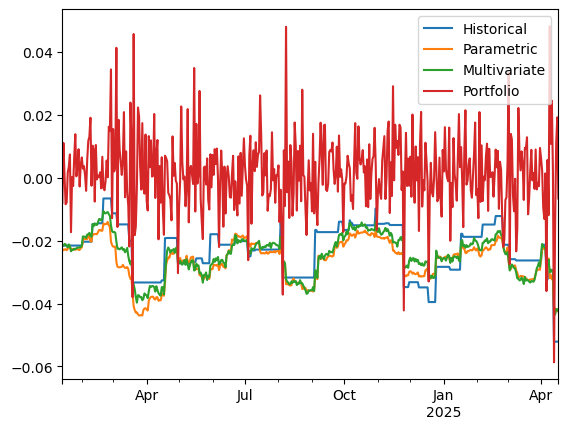

In [144]:
var_data.plot()
plt.show()

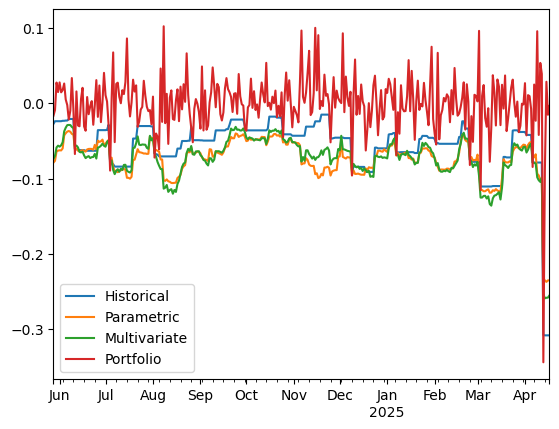

In [145]:
current_var_data.plot()
plt.show()


In [146]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.034783,0.019565,0.019565
Kupiec Stat,2.498558,11.554945,11.554945
P-value,0.113951,0.000676,0.000676


In [147]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064615,0.024615,0.024615
Kupiec Stat,1.343495,5.380086,5.380086
P-value,0.246419,0.020368,0.020368


# Principal Component Analysis

## Historical PCA

In [150]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76403187, 0.1058325 , 0.04944329, 0.04399913, 0.0366932 ])

In [151]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.018345
ADAUSDT      0.019328
ALGOUSDT     0.020460
APTUSDT      0.017845
ARBUSDT      0.019652
ATOMUSDT     0.017403
AVAXUSDT     0.020030
BCHUSDT      0.015833
BNBUSDT      0.009101
BONKUSDT     0.024800
BTCUSDT      0.010179
CRVUSDT      0.021239
DEXEUSDT     0.012900
DOGEUSDT     0.019133
DOTUSDT      0.017949
EOSUSDT      0.018192
ETCUSDT      0.016458
ETHUSDT      0.014121
FDUSDUSDT    0.000069
FETUSDT      0.023283
FILUSDT      0.019851
FLOWUSDT     0.019150
GRTUSDT      0.021709
HBARUSDT     0.019327
ICPUSDT      0.018011
IMXUSDT      0.020273
INJUSDT      0.021425
IOTAUSDT     0.021365
JASMYUSDT    0.021906
LDOUSDT      0.021293
LINKUSDT     0.018361
LTCUSDT      0.013705
MKRUSDT      0.013700
NEARUSDT     0.021872
NEXOUSDT     0.011818
OMUSDT       0.014110
OPUSDT       0.020246
PAXGUSDT     0.000286
PEPEUSDT     0.024624
QNTUSDT      0.015653
RAYUSDT      0.021572
SANDUSDT     0.021407
SEIUSDT      0.021541
SHIBUSDT     0.018437
SOLUSDT      0.017289
STXUSDT   

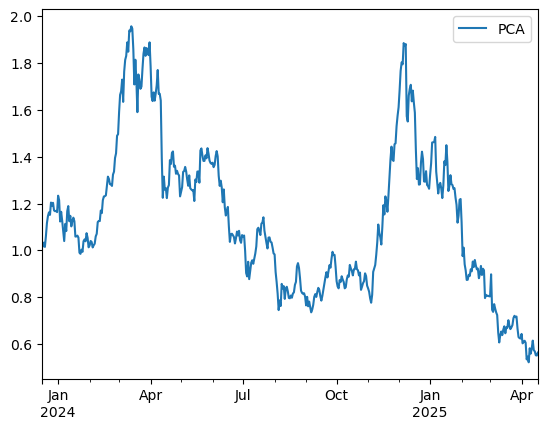

In [152]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

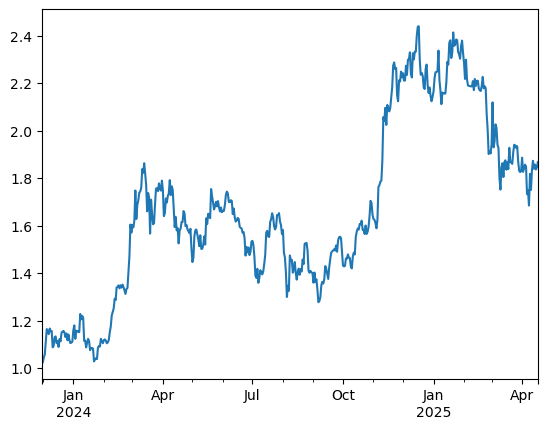

In [153]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [154]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.447475
WBETHUSDT    0.465907
ETHUSDT      0.466279
DOTUSDT      0.499357
ETCUSDT      0.500078
ATOMUSDT     0.514456
NEXOUSDT     0.522183
AVAXUSDT     0.554666
WBTCUSDT     0.558299
BTCUSDT      0.558654
FILUSDT      0.578541
IOTAUSDT     0.579529
ARBUSDT      0.585838
GRTUSDT      0.591324
LINKUSDT     0.613175
VETUSDT      0.624207
ALGOUSDT     0.633205
SOLUSDT      0.649924
EOSUSDT      0.657915
dtype: float64

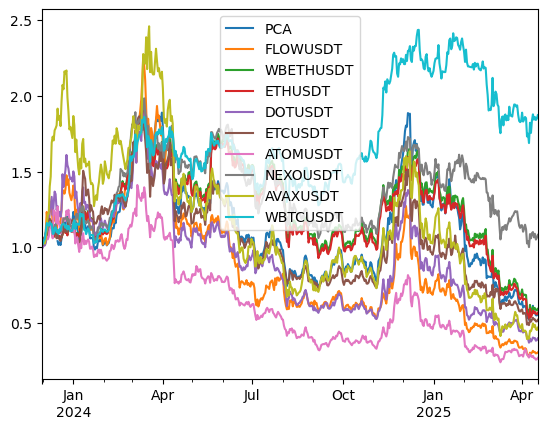

In [155]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

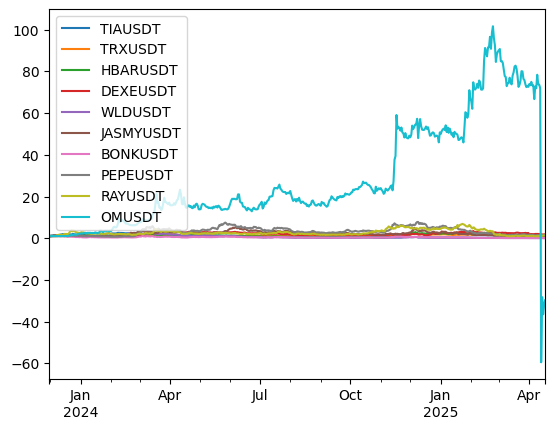

In [156]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [158]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.49831836, 0.32084482, 0.0740803 , 0.06209307, 0.04466345])

In [159]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049509
OMUSDT       0.295167
SOLUSDT      0.088663
JASMYUSDT    0.131870
TRXUSDT      0.036746
ETHUSDT      0.070749
BBUSDT       0.155008
BNBUSDT      0.050246
PEPEUSDT     0.119533
PAXGUSDT     0.002510
Name: PC1, dtype: float64

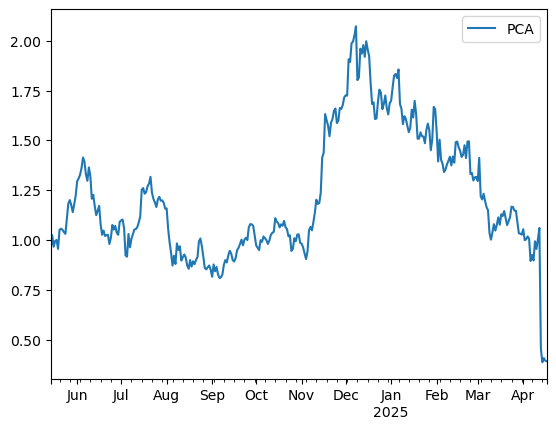

In [160]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

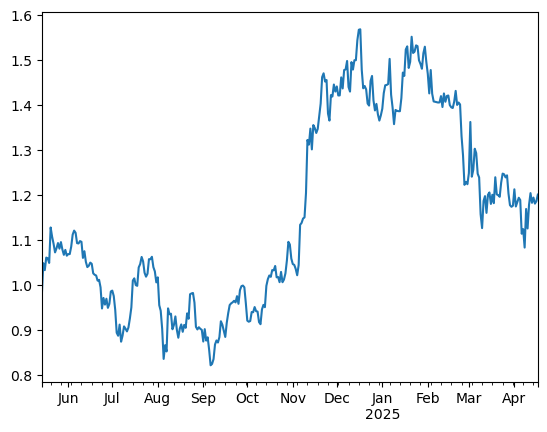

In [161]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [162]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.774077
BTCUSDT      0.785645
BNBUSDT      0.794436
SOLUSDT      0.806231
PAXGUSDT     0.985301
JASMYUSDT    1.017435
PEPEUSDT     1.051690
BBUSDT       1.052396
TRXUSDT      1.139331
dtype: float64

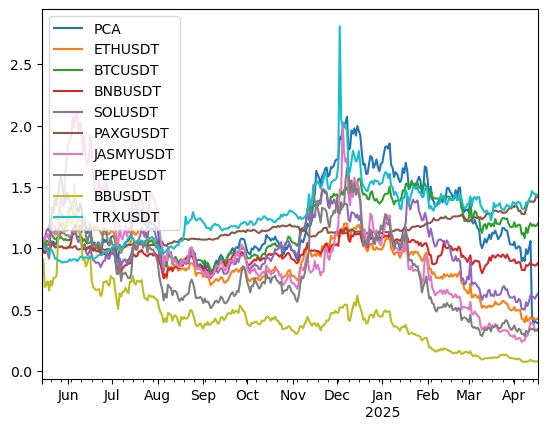

In [163]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [165]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.861233
BBUSDT       1.593353
JASMYUSDT    1.422245
SOLUSDT      1.268991
ETHUSDT      1.048718
BTCUSDT      1.000000
OMUSDT       0.942689
BNBUSDT      0.659651
TRXUSDT      0.327992
PAXGUSDT     0.037931
Name: BTCUSDT, dtype: float64

In [166]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.046400
OMUSDT       1.848068
BBUSDT       1.682486
SOLUSDT      1.680569
PEPEUSDT     1.593120
ETHUSDT      1.573992
BTCUSDT      1.000000
BNBUSDT      0.511783
TRXUSDT      0.161494
PAXGUSDT     0.046534
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [168]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [169]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.286151
ETHUSDT,0.272441
PEPEUSDT,0.129467
BBUSDT,0.129327
BNBUSDT,0.097322
JASMYUSDT,0.078930
SOLUSDT,0.053972
OMUSDT,0.017466
PAXGUSDT,0.012033
TRXUSDT,-0.015095


### Regression to PCA

In [171]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.25663068352879004

In [172]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.324745
BNBUSDT      1.184741
PCA          1.000000
ETHUSDT      0.987680
SOLUSDT      0.728491
PAXGUSDT     0.616783
JASMYUSDT    0.471333
PEPEUSDT     0.454658
BBUSDT       0.418422
TRXUSDT      0.292615
OMUSDT       0.093247
dtype: float64

In [173]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.637038
BTCUSDT      1.472349
PCA          1.000000
ETHUSDT      0.883352
TRXUSDT      0.809718
SOLUSDT      0.796369
PEPEUSDT     0.643072
BBUSDT       0.569942
JASMYUSDT    0.481109
PAXGUSDT     0.227015
OMUSDT       0.038760
dtype: float64

### Correlation Matrix

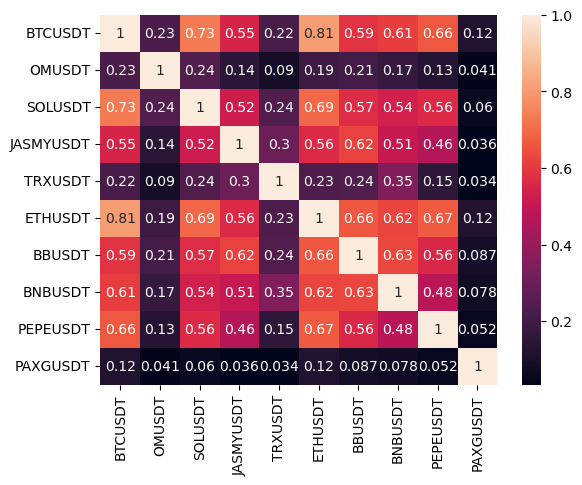

In [175]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

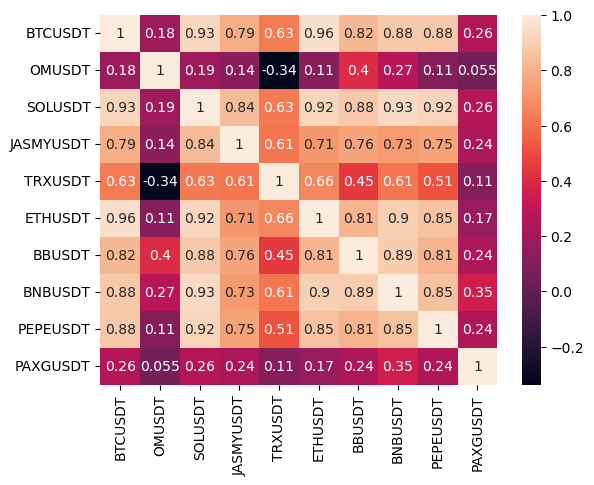

In [176]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [177]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [178]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

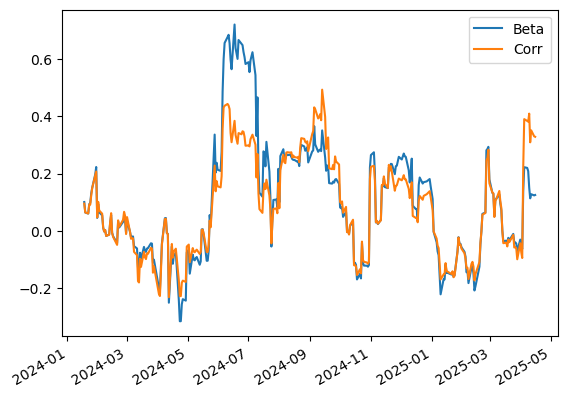

In [179]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [181]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,OMUSDT,SOLUSDT,JASMYUSDT,TRXUSDT,ETHUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.626168,0.000000,0.150876,0.222957,0.000000,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932282,0.000000,0.000000,0.000000,0.000000,0.067718
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.260704,0.019283,0.086231,0.000000,0.238042,0.000000,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453916,0.000000,0.000000,0.000000,0.000000,0.546084
2024-09-02,0.000000,0.435186,0.000000,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.176734,0.000000,0.000000,0.526886,0.166022,0.000000,0.000000,0.130357,0.000000


In [182]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TIAUSDT,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT
2024-09-09,0.639229,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.351173,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2024-10-09,0.134894,0.0,0.0,0.016623,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.214322,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2024-11-08,0.134894,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2024-12-08,0.134894,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.020917,0.203922
2025-01-07,0.134894,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2025-02-06,0.134894,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2025-03-08,0.134894,0.0,0.0,0.000000,0.0,0.0,0.0,0.193178,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2025-04-07,0.134894,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2025-04-17,0.134894,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.236826,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [183]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

PAXGUSDT    0.545908
TRXUSDT     0.236826
AAVEUSDT    0.134894
RAYUSDT     0.082372
SHIBUSDT    0.000000
LTCUSDT     0.000000
Name: 2025-04-17 00:00:00, dtype: float64

In [184]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
